# Exploraition of unassigned transcripts
This scripts aim is to find the differences in assigned transcripts. Therefore we look at correlation of total transcript counts on a per gene basis.
In the best case one would examine the correlation on a per cell basis, however there is no trivial mapping of cells to each other across methods.

You can use the tmp_enact environment to run this script

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

bin_8x8_path = "/srv/gstore/projects/p37785/EzPyzAnndataReportApp_2025-07-23--15-45-57/AnndataReportApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/report/adata_processed.h5ad"
bin_16x16_path = "/srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_016um/filtered_feature_bc_matrix.h5"
cells_b2c_path = "/srv/gstore/projects/p37785/EzPyzBin2CellApp_2025-06-29--17-56-50/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cdata.h5ad"
cells_enact_path = "/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"
cells_xseg_path = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-06-02--15-53-26/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"


adata_bin_8 = sc.read_h5ad(bin_8x8_path)
adata_bin_16 = sc.read_10x_h5(bin_16x16_path)
adata_cells_b2c = sc.read_h5ad(cells_b2c_path)
adata_cells_enact = sc.read_h5ad(cells_enact_path)
adata_cells_xseg = sc.read_h5ad(cells_xseg_path)

/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Correlation matrix:
              bin_8x8  cells_b2c  cells_enact  cells_xseg
bin_8x8      1.000000   0.999166     0.998526    0.999749
cells_b2c    0.999166   1.000000     0.999855    0.998772
cells_enact  0.998526   0.999855     1.000000    0.997922
cells_xseg   0.999749   0.998772     0.997922    1.000000


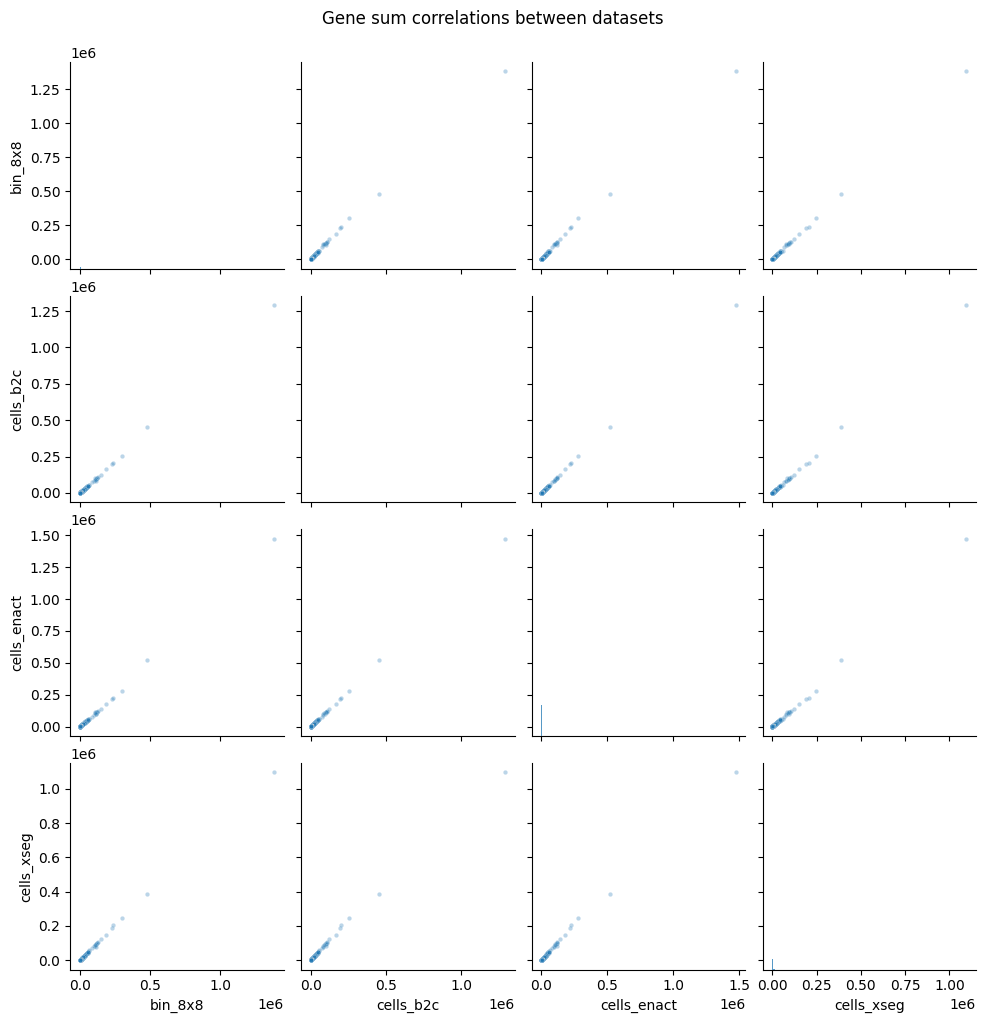

In [ ]:
import pandas as pd
import seaborn as sns

# Sum expression for every gene in each dataset
gene_sums = {
    "bin_8x8": np.array(adata_bin_8.X.sum(axis=0)).flatten(),
    "bin_16x16": np.array(adata_bin_16.X.sum(axis=0)).flatten(),
    "cells_b2c": np.array(adata_cells_b2c.X.sum(axis=0)).flatten(),
    "cells_enact": np.array(adata_cells_enact.X.sum(axis=0)).flatten(),
    "cells_xseg": np.array(adata_cells_xseg.X.sum(axis=0)).flatten(),
}

# Find common genes (by gene name)
gene_names = set(adata_bin_8.var_names) \
    & set(adata_bin_16.var_names) \
    & set(adata_cells_b2c.var_names) \
    & set(adata_cells_enact.var_names) \
    & set(adata_cells_xseg.var_names)
gene_names = sorted(list(gene_names))

# Restrict sums to common genes and stack into a DataFrame

def get_sums_for_genes(adata, gene_names):
    idx = adata.var_names.get_indexer(gene_names)
    return np.array(adata.X[:, idx].sum(axis=0)).flatten()

df = pd.DataFrame({
    "bin_8x8": get_sums_for_genes(adata_bin_8, gene_names),
    "cells_b2c": get_sums_for_genes(adata_cells_b2c, gene_names),
    "cells_enact": get_sums_for_genes(adata_cells_enact, gene_names),
    "cells_xseg": get_sums_for_genes(adata_cells_xseg, gene_names),
}, index=gene_names)

# Compute correlation matrix
corr = df.corr()
print("Correlation matrix:")
print(corr)

# Scatterplots

sns.pairplot(df, plot_kws={'alpha':0.3, 's':10})
plt.suptitle("Gene sum correlations between datasets", y=1.02)
plt.show()

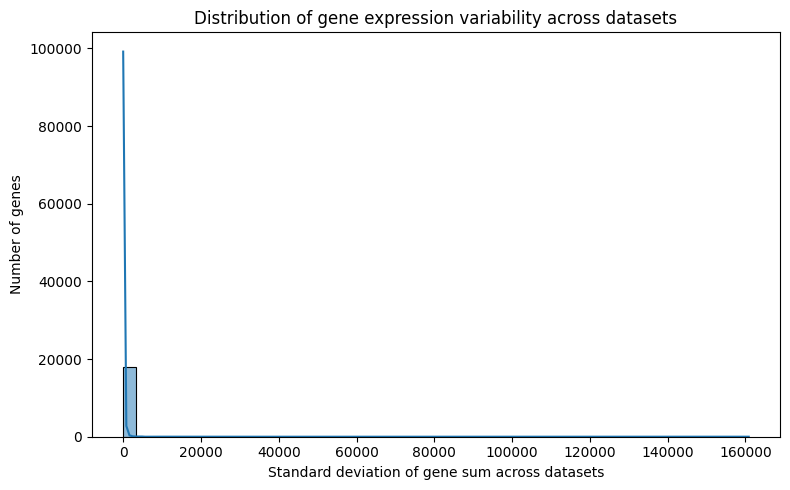

In [ ]:
# Calculate the standard deviation across datasets for each gene
df['std'] = df.std(axis=1)

plt.figure(figsize=(8, 5))
sns.histplot(df['std'], bins=50, kde=True)
plt.xlabel('Standard deviation of gene sum across datasets')
plt.ylabel('Number of genes')
plt.title('Distribution of gene expression variability across datasets')
plt.tight_layout()
plt.show()

In [ ]:
num_above_10000 = (df['std'] > 10000).sum()
print(f"Number of genes with std > 10000: {num_above_10000}")

Number of genes with std > 10000: 14


In [ ]:
# Sort genes by standard deviation (most different at the top)
most_different_genes = df['std'].sort_values(ascending=False).head(num_above_10000)

# Display the top genes with most different count levels across datasets
print("Top genes with most different count levels across datasets:")
print(most_different_genes)

Top genes with most different count levels across datasets:
IGKC       160847.672832
IGHG1       55888.043110
MT-CO3      26189.532586
CD74        18136.326944
SPP1        15375.387220
SCGB1A1     15249.292612
SFTPB       14779.835228
IGHA1       12900.129776
TMSB10      12175.918776
FTH1        11045.453476
MT-ATP6     10759.236468
TMSB4X      10297.034240
ACTB        10212.943604
B2M         10158.110366
Name: std, dtype: float64


In [ ]:
# Extract the gene names for the most different genes
top_genes = most_different_genes.index.tolist()

# Create a table with transcript counts for each dataset for these genes
table = df.loc[top_genes, ["bin_8x8", "cells_b2c", "cells_enact", "cells_xseg"]]
table.index.name = "Gene"
def color_scale(val, ref):
    # Compute relative deviation
    if ref == 0:
        return ''
    diff = val - ref
    rel = diff / abs(ref)
    # Clamp rel to [-1, 1] for color scaling
    rel = max(min(rel, 1), -1)
    if rel > 0:
        # Green: more intense for higher rel
        green = int(230 - 100 * rel)
        color = f'background-color: rgb({green},255,{green})'
    elif rel < 0:
        # Red: more intense for lower rel
        red = int(230 - 100 * abs(rel))
        color = f'background-color: rgb(255,{red},{red})'
    else:
        color = ''
    return color

def style_row(row):
    ref = row['cells_xseg']
    return [
        color_scale(row['bin_8x8'], ref),
        color_scale(row['cells_b2c'], ref),
        color_scale(row['cells_enact'], ref),
        ''  # No highlight for reference column
    ]

styled_table = table.style.apply(style_row, axis=1)
styled_table

,bin_8x8,cells_b2c,cells_enact,cells_xseg
Gene,,,,
IGKC,1380892.000000,1290629.414270,1472735.750000,1096149.250000
IGHG1,478104.000000,454588.509592,519248.875000,385809.593750
MT-CO3,303020.000000,252937.582184,275550.968750,244517.390625
CD74,227147.000000,195841.027754,216533.750000,187880.593750
SPP1,112832.000000,83891.266328,95987.945312,78019.843750
SCGB1A1,185375.000000,166098.642068,176252.156250,149789.468750
SFTPB,235231.000000,203857.322390,221980.234375,205785.875000
IGHA1,108756.000000,99475.046543,114858.046875,85209.703125
TMSB10,147588.000000,125063.873898,137373.375000,120743.585938


# 🧬 Biological Interpretation of Highly Variable Genes

The genes showing the highest variability across different segmentation methods reveal important biological and technical insights:

## 🔬 **Immunoglobulin Genes (Adaptive Immunity)**

**IGKC (Immunoglobulin Kappa Constant)** - *Most variable gene*
- **Function**: Light chain component of antibodies
- **Significance**: Indicates B-cell/plasma cell presence and activity
- **Variability reason**: These cells may be spatially clustered and sensitive to segmentation boundaries

**IGHG1 (Immunoglobulin Heavy Chain Gamma 1)**
- **Function**: Heavy chain of IgG1 antibodies
- **Significance**: Marks mature plasma cells producing specific antibody subclass
- **Clinical relevance**: Important for immune response in lung cancer microenvironment

**IGHA1 (Immunoglobulin Heavy Chain Alpha 1)**
- **Function**: Heavy chain of IgA1 antibodies
- **Significance**: Mucosal immunity marker, relevant in lung tissue
- **Variability reason**: Plasma cells often form distinct clusters that segmentation methods may capture differently

## 🫁 **Lung-Specific Markers**

**SCGB1A1 (Secretoglobin Family 1A Member 1)**
- **Function**: Clara cell secretory protein, lung surfactant component
- **Significance**: Marker of Club cells (Clara cells) in terminal bronchioles
- **Clinical relevance**: Loss associated with lung injury and cancer progression

**SFTPB (Surfactant Protein B)**
- **Function**: Essential component of pulmonary surfactant
- **Significance**: Marker of alveolar type II pneumocytes
- **Variability reason**: These specialized cells have distinct morphology that may be segmented differently

## ⚡ **Mitochondrial Genes (Energy Metabolism)**

**MT-CO3 (Mitochondrially Encoded Cytochrome C Oxidase III)**
- **Function**: Key component of electron transport chain
- **Significance**: Indicates cellular metabolic activity
- **Variability reason**: May reflect differences in cell size/volume captured by segmentation methods

**MT-ATP6 (Mitochondrially Encoded ATP Synthase 6)**
- **Function**: ATP synthesis in mitochondria
- **Significance**: Essential for cellular energy production
- **Technical note**: High mitochondrial gene expression may indicate metabolically active cell regions

## 🏠 **Housekeeping/Structural Genes**

**ACTB (Actin Beta)**
- **Function**: Major component of cytoskeleton
- **Significance**: Essential structural protein in all cells
- **Variability reason**: May reflect differences in cell shape/size captured during segmentation

**TMSB10 & TMSB4X (Thymosin Beta 10 & X)**
- **Function**: Actin-binding proteins regulating cytoskeleton
- **Significance**: Control cell motility and shape
- **Clinical relevance**: Often dysregulated in cancer for invasion/metastasis

**FTH1 (Ferritin Heavy Chain 1)**
- **Function**: Iron storage and cellular iron homeostasis
- **Significance**: Protective against oxidative stress
- **Cancer relevance**: Often upregulated in tumors due to increased iron needs

## 🛡️ **Antigen Presentation**

**CD74 (CD74 Molecule)**
- **Function**: MHC class II invariant chain
- **Significance**: Critical for antigen presentation to T cells
- **Variability reason**: Expressed in antigen-presenting cells (dendritic cells, macrophages, B cells)

**B2M (Beta-2-Microglobulin)**
- **Function**: Component of MHC class I molecules
- **Significance**: Present on all nucleated cells for antigen presentation
- **Clinical relevance**: Elevated in various cancers and immune activation

## 🦴 **Extracellular Matrix/Tumor Microenvironment**

**SPP1 (Secreted Phosphoprotein 1/Osteopontin)**
- **Function**: Extracellular matrix protein, cytokine
- **Significance**: Promotes cell adhesion, migration, and survival
- **Cancer relevance**: Often overexpressed in tumors, promotes metastasis and immune evasion


In [ ]:
# Create a summary analysis of gene categories
print("📊 GENE CATEGORY ANALYSIS")
print("=" * 50)

# Categorize the genes
gene_categories = {
    'Immunoglobulins': ['IGKC', 'IGHG1', 'IGHA1'],
    'Lung-specific': ['SCGB1A1', 'SFTPB'], 
    'Mitochondrial': ['MT-CO3', 'MT-ATP6'],
    'Cytoskeleton': ['ACTB', 'TMSB10', 'TMSB4X'],
    'Antigen presentation': ['CD74', 'B2M'],
    'ECM/Tumor microenv': ['SPP1'],
    'Iron metabolism': ['FTH1']
}

# Calculate total variability by category
category_variability = {}
for category, genes in gene_categories.items():
    present_genes = [g for g in genes if g in most_different_genes.index]
    if present_genes:
        total_std = sum(most_different_genes[g] for g in present_genes)
        category_variability[category] = {
            'total_std': total_std,
            'gene_count': len(present_genes),
            'genes': present_genes
        }

# Sort categories by total variability
sorted_categories = sorted(category_variability.items(), 
                          key=lambda x: x[1]['total_std'], reverse=True)

print("Gene categories ranked by total variability:")
for i, (category, data) in enumerate(sorted_categories, 1):
    print(f"{i}. {category}:")
    print(f"   Total variability: {data['total_std']:,.0f}")
    print(f"   Genes ({data['gene_count']}): {', '.join(data['genes'])}")
    print()

# Calculate what percentage of total variability comes from immune genes
immune_genes = ['IGKC', 'IGHG1', 'IGHA1', 'CD74', 'B2M']
immune_variability = sum(most_different_genes[g] for g in immune_genes if g in most_different_genes.index)
total_variability = most_different_genes.sum()
immune_percentage = (immune_variability / total_variability) * 100

print(f"🎯 KEY INSIGHTS:")
print(f"• Immune-related genes account for {immune_percentage:.1f}% of total variability")
print(f"• Lung-specific markers show high segmentation sensitivity")
print(f"• Mitochondrial genes suggest metabolic differences between methods")
print(f"• Housekeeping genes unexpectedly variable - indicates technical differences")

# Identify which segmentation method captures each gene best
print(f"\n🏆 SEGMENTATION METHOD PERFORMANCE:")
print("Gene → Best capturing method:")
for gene in most_different_genes.index[:10]:  # Top 10 most variable
    gene_data = df.loc[gene, ['bin_8x8', 'cells_b2c', 'cells_enact', 'cells_xseg']]
    best_method = gene_data.idxmax()
    max_count = gene_data.max()
    print(f"{gene:12s} → {best_method:12s} ({max_count:>8,.0f} transcripts)")

📊 GENE CATEGORY ANALYSIS
Gene categories ranked by total variability:
1. Immunoglobulins:
   Total variability: 229,636
   Genes (3): IGKC, IGHG1, IGHA1

2. Mitochondrial:
   Total variability: 36,949
   Genes (2): MT-CO3, MT-ATP6

3. Cytoskeleton:
   Total variability: 32,686
   Genes (3): ACTB, TMSB10, TMSB4X

4. Lung-specific:
   Total variability: 30,029
   Genes (2): SCGB1A1, SFTPB

5. Antigen presentation:
   Total variability: 28,294
   Genes (2): CD74, B2M

6. ECM/Tumor microenv:
   Total variability: 15,375
   Genes (1): SPP1

7. Iron metabolism:
   Total variability: 11,045
   Genes (1): FTH1

🎯 KEY INSIGHTS:
• Immune-related genes account for 67.2% of total variability
• Lung-specific markers show high segmentation sensitivity
• Mitochondrial genes suggest metabolic differences between methods
• Housekeeping genes unexpectedly variable - indicates technical differences

🏆 SEGMENTATION METHOD PERFORMANCE:
Gene → Best capturing method:
IGKC         → cells_enact  (1,472,736 tr